In [13]:
%matplotlib inline
import os
import pandas as pd
import csv
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.regularizers import l2
import matplotlib.pyplot as plt

Let's get our data!

In [2]:
curr_dir = os.path.dirname('__file__')
file_path = os.path.join(curr_dir, "temps.csv")

In [3]:
with open(file_path, 'rb') as csvfile:
    reader = csv.reader(csvfile)
    data = list(reader)

data = data[1:-3]
for row in data:
    row[1] = float(row[1].replace("?", ""))
df = pd.DataFrame(data, columns=['Date', 'Temperature'])
df = pd.DataFrame(df.Temperature)

We'd like to call attention to the create_epochs function. This function creates an array of "epochs", where each epoch is a "snapshot" of the data over a certain time-window. For example, let's say we have an `X` matrix with 10 features, with values every day for 2 years (`X` is a 730x10 matrix). We want our neural network to be able to predict the value of target `Y` (a length 730 vector) at a given day, given the previous 30 days of data. We then will feed the network a series of epochs, a 700x30x10 matrix of data (we have 700 snapshots, each 30 days long, with 10 features). The network will try to learn a 700x1 matrix (or a length 700 vector, depending on `ravel`), which contains the value of `Y` at the timestep following the training window.

In [4]:
def create_epochs(data, ravel=False, n_prev=14):

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)
    if (ravel):
        alsY = alsY.ravel()

    return alsX, alsY

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    
    X_train, y_train = create_epochs(df.iloc[0:ntrn])
    X_test, y_test = create_epochs(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

In [5]:
(X_train, y_train), (X_test, y_test) = train_test_split(df)  # retrieve data

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: FutureWarning: slice indexers when using iloc should be integers and not floating point
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: FutureWarning: slice indexers when using iloc should be integers and not floating point


This is where the Keras starts. Basically, Keras is a wrapper on top of Theano, similar to Lasagne, that abstracts out a lot of the complicated symbolic math programming you have to do. All we have to do is create a `Sequential` mode, and then add layers to it. In this case, we use an LSTM hidden layer with 10 neurons, and then a single neuron output layer (Keras calls these `Dense` layers. They're just your basic linear-weighted layer with an optional activation).

One thing to note is that we did not apply an activation function to our output layer. This means that the output is simply a linear combination of the hidden layer's activities. You can see how this allows the output to take on any value (since the weights can be anything). This is because we don't really know the range of possible temperatures for the weather (or at least, we can't come up with definitive boundaries). If we were to apply, say, a tanh to our output, our network would only be able to guess temperatures between -1 to 1.

Another cool thing we did is parameter tuning and regularization. As discussed earlier (like, way earlier), regularizing our networks weights can help overfitting. We try 9 combinations for 3 different regularization parameters for the synapses between the input and hidden, and the hidden and output, to determine the best combination.

In [6]:
in_out_neurons = 1  
hidden_neurons = 10

l2_possibilities_1 = np.logspace(-1, 1, 3)
l2_possibilities_2 = np.logspace(-2, 0, 3)

costs = []

best_model = None
best_score = 1000

for val_1 in l2_possibilities_1:
    temp = []
    for val_2 in l2_possibilities_2:
        model = Sequential()
        model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, W_regularizer=l2(val_1), activation='tanh'))
        model.add(Dense(1, W_regularizer=l2(val_2)))
        model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=.01))
        model.fit(X_train, y_train, nb_epoch=10, verbose=0)
        predicted = model.predict(X_test)
        rmse = ((predicted - y_test) ** 2).mean(axis=0)
        if (rmse < best_score):
            best_score = rmse
            best_model = model
            print "RMSE for l2 of %0.2f, %0.2f: %0.2f. This is currently the best model!" % (val_1, val_2, rmse)
        else:
            print "RMSE for l2 of %0.2f, %0.2f: %0.2f" % (val_1, val_2, rmse)
        temp.append(rmse)
    costs.append(temp)

RMSE for l2 of 0.10, 0.01: 15.31. This is currently the best model!
RMSE for l2 of 0.10, 0.10: 14.53. This is currently the best model!
RMSE for l2 of 0.10, 1.00: 20.14
RMSE for l2 of 1.00, 0.01: 13.93. This is currently the best model!
RMSE for l2 of 1.00, 0.10: 13.35. This is currently the best model!
RMSE for l2 of 1.00, 1.00: 19.55
RMSE for l2 of 10.00, 0.01: 19.12
RMSE for l2 of 10.00, 0.10: 15.10
RMSE for l2 of 10.00, 1.00: 23.49


/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:489: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


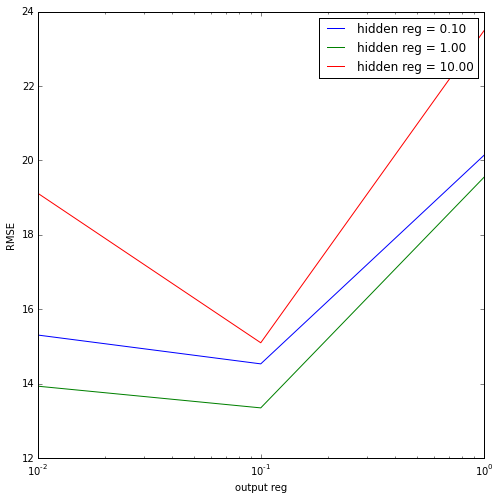

In [14]:
for c, l in zip(costs, l2_possibilities_1):
    plt.semilogx(l2_possibilities_2, c, label="hidden reg = %0.2f" % l)
plt.xlabel('output reg')
plt.ylabel('RMSE')
    
plt.gcf().set_size_inches(8, 8)
    
plt.legend()

A cool trend! The combination of 1.0, 0.1 parameters for the hidden and output layers seems to be pretty good.

Here's our model's results! We compare it to the a baseline model, which just predicts the previous temperature it saw. A small improvement, but an improvement nonetheless.

In [8]:
predicted = best_model.predict(X_test)
print "Error on test set: %.1f" % ((best_model.predict(X_test) - y_test) ** 2).mean()
print "Previous day error: %.1f" % ((X_test[:, -1, :] - y_test) ** 2).mean()

Error on test set: 13.3
Previous day error: 14.7


And, just because we like visualizations, check out the models predictions! It has an interesting (and expected) lag, where its always a day behind the real weather. This is likely because, generally speaking, the model is not sure about the direction the weather will swing, and predicts something close to the previous day's data. The small swings it does predict do seem to improve accuracy, though.

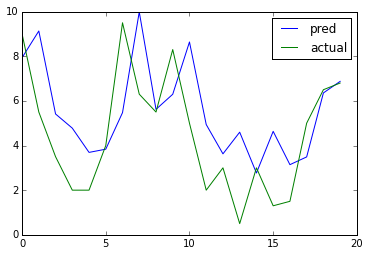

In [16]:
predicted = best_model.predict(X_test)
plt.plot(pd.DataFrame(predicted)[40:60])
plt.plot(pd.DataFrame(y_test)[40:60])
plt.legend(['pred', 'actual'])